In [21]:
#Use this window to import packages you will use later
#When you first start working or import a new package, this cell needs to be run before doing anything else.

import numpy as np

import pylab

import matplotlib
import matplotlib.gridspec as gridspec

import scipy

import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.table import Table
import matplotlib.pyplot as plt

import regions

import pyspeckit as psk

from spectral_cube import SpectralCube

from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs 

# Suppress warnings we don't care about:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
# Embeds plots in the Jupyter window 
%matplotlib inline                             

matplotlib.rc('text', usetex=True)
#matplotlib.rc('font', family='sans-serif')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

datadir = "../data/"
linedir = datadir + "3channel_masked_high_resolution/line_masked/"
lores_linedire = datadir + "3_line_masked/"
extdir = datadir + "line_extinction_maps/"

filenames = {
    'arII': 'NGC253_ArII_7.0.line_smooth_regrid_maskch1.fits',
    'arIII': 'NGC253_ArIII_9.0.line_smooth_regrid_maskch1.fits',
    'c2h2': 'NGC253_C2H2_13.7.line_smooth_regrid_maskch1.fits',
    'clII': 'NGC253_ClII_14.4.line_smooth_regrid_maskch1.fits',
    'co2': 'NGC253_CO2_15.0.line_smooth_regrid_maskch1.fits',
    'feII_5.3': 'NGC253_FeII_5.3.line_smooth_regrid_maskch1.fits',
    'h5a': 'NGC253_H5a_7.5.line_smooth_regrid_maskch1.fits',
    'h5b': 'NGC253_H5b_7.5.line_smooth_regrid_maskch1.fits',
    'h6a': 'NGC253_H6a_12.4.line_smooth_regrid_maskch1.fits',
    'h6d': 'NGC253_H6d_5.1.line_smooth_regrid_maskch1.fits',
    'h6g': 'NGC253_H6g_5.9.line_smooth_regrid_maskch1.fits',
    'h7b': 'NGC253_H7b_11.3.line_smooth_regrid_maskch1.fits',
    'h7d': 'NGC253_H7d_7.5.line_smooth_regrid_maskch1.fits',
    'h7e_6.0': 'NGC253_H7e_6.0.line_smooth_regrid_maskch1.fits',
    'h7e_6.8': 'NGC253_H7e_6.8.line_smooth_regrid_maskch1.fits',
    'h7g': 'NGC253_H7g_8.8.line_smooth_regrid_maskch1.fits',
    'h7i': 'NGC253_H7i_5.5.line_smooth_regrid_maskch1.fits',
    'h7k': 'NGC253_H7k_5.4.line_smooth_regrid_maskch1.fits',
    'h7t': 'NGC253_H7t_5.7.line_smooth_regrid_maskch1.fits',
    'h7z': 'NGC253_H7z_6.3.line_smooth_regrid_maskch1.fits',
    'h8b': 'NGC253_H8b_16.2.line_smooth_regrid_maskch1.fits',
    'h8g': 'NGC253_H8g_12.4.line_smooth_regrid_maskch1.fits',
    'h8t': 'NGC253_H8t_7.8.line_smooth_regrid_maskch1.fits',
    'hcn': 'NGC253_HCN_14.0.line_smooth_regrid_maskch1.fits',
    'he': 'NGC253_He_6.7.line_smooth_regrid_maskch1.fits',
    'mgV_13.5': 'NGC253_MgV_13.5.line_smooth_regrid_maskch1.fits',
    'mgV_5.6': 'NGC253_MgV_5.6.line_smooth_regrid_maskch1.fits',
    'neII': 'NGC253_NeII_12.8.line_smooth_regrid_maskch1.fits',
    'neIII': 'NGC253_NeIII_15.6.line_smooth_regrid_maskch1.fits',
    'neV': 'NGC253_NeV_14.3.line_smooth_regrid_maskch1.fits',
    'neVI': 'NGC253_NeVI_7.7.line_smooth_regrid_maskch1.fits',
    'niII_10.7': 'NGC253_NiII_10.7.line_smooth_regrid_maskch1.fits',
    'niII_6.6': 'NGC253_NiII_6.6.line_smooth_regrid_maskch1.fits',
    'niIII': 'NGC253_NiIII_7.3.line_smooth_regrid_maskch1.fits',
    'pIII': 'NGC253_PIII_17.9.line_smooth_regrid_maskch1.fits',
    's1': 'NGC253_S1_17.0.line_smooth_regrid_maskch1.fits',
    's2': 'NGC253_S2_12.3.line_smooth_regrid_maskch1.fits',
    's3': 'NGC253_S3_9.7.line_smooth_regrid_maskch1.fits',
    's4': 'NGC253_S4_8.0.line_smooth_regrid_maskch1.fits',
    's5': 'NGC253_S5_6.9.line_smooth_regrid_maskch1.fits',
    's6': 'NGC253_S6_6.1.line_smooth_regrid_maskch1.fits',
    's7_1': 'NGC253_S7_1-1_5.8.line_smooth_regrid_maskch1.fits',
    's7_5': 'NGC253_S7_5.5.line_smooth_regrid_maskch1.fits',
    's8': 'NGC253_S8_5.1.line_smooth_regrid_maskch1.fits',
    's9': 'NGC253_S9_5.0.line_smooth_regrid_maskch1.fits',
    'sIV_10.5': 'NGC253_SIV_10.5.line_smooth_regrid_maskch1.fits',
    'u5_5.65': 'NGC253_U_5.65_5.7.line_smooth_regrid_maskch1.fits',
    'u5_5.74': 'NGC253_U_5.74_5.7.line_smooth_regrid_maskch1.fits',
    'u1': 'NGC253_U1_6.1.line_smooth_regrid_maskch1.fits',
    'u10': 'NGC253_U10_10.9.line_smooth_regrid_maskch1.fits'

}



extinction_maps = {
    'arII': '6.99_micron_extinction_map_mags.fits',
    'arIII': '8.99_micron_extinction_map_mags.fits',
    'c2h2': '13.7_micron_extinction_map_mags.fits',
    'clII': '14.37_micron_extinction_map_mags.fits',
    'co2': '15.0_micron_extinction_map_mags.fits',
    'feII_5.3': '5.34_micron_extinction_map_mags.fits',
    'h5a': '7.5_micron_extinction_map_mags.fits',
    'h5b': '7.5_micron_extinction_map_mags.fits',
    'h6a': '12.39_micron_extinction_map_mags.fits',
    'h6d': '5.13_micron_extinction_map_mags.fits',
    'h6g': '5.91_micron_extinction_map_mags.fits',
    'h7b': '11.31_micron_extinction_map_mags.fits',
    'h7d': '7.5_micron_extinction_map_mags.fits',
    'h7e_6.0': '5.96_micron_extinction_map_mags.fits',
    'h7e_6.8': '6.77_micron_extinction_map_mags.fits',
    'h7g': '8.76_micron_extinction_map_mags.fits',
    'h7i': '5.51_micron_extinction_map_mags.fits',
    'h7k': '5.38_micron_extinction_map_mags.fits',
    'h7t': '5.71_micron_extinction_map_mags.fits',
    'h7z': '6.29_micron_extinction_map_mags.fits',
    'h8b': '16.21_micron_extinction_map_mags.fits',
    'h8g': '12.39_micron_extinction_map_mags.fits',
    'h8t': '7.78_micron_extinction_map_mags.fits',
    'hcn': '14.0_micron_extinction_map_mags.fits',
    'he': '6.72_micron_extinction_map_mags.fits',
    'mgV_13.5': '13.54_micron_extinction_map_mags.fits',
    'mgV_5.6': '5.61_micron_extinction_map_mags.fits',
    'neII': '12.81_micron_extinction_map_mags.fits',
    'neIII': '15.55_micron_extinction_map_mags.fits',
    'neV': '14.32_micron_extinction_map_mags.fits',
    'neVI': '7.65_micron_extinction_map_mags.fits',
    'niII_10.7': '10.68_micron_extinction_map_mags.fits',
    'niII_6.6': '6.64_micron_extinction_map_mags.fits',
    'niIII': '7.35_micron_extinction_map_mags.fits',
    'pIII': '17.88_micron_extinction_map_mags.fits',
    's1': '17.03_micron_extinction_map_mags.fits',
    's2': '12.28_micron_extinction_map_mags.fits',
    's3': '9.66_micron_extinction_map_mags.fits',
    's4': '8.03_micron_extinction_map_mags.fits',
    's5': '6.91_micron_extinction_map_mags.fits',
    's6': '6.11_micron_extinction_map_mags.fits',
    's7_1': '5.81_micron_extinction_map_mags.fits',
    's7_5': '5.51_micron_extinction_map_mags.fits',
    's8': '5.13_micron_extinction_map_mags.fits',
    's9': '5.05_micron_extinction_map_mags.fits',
    'sIV_10.5': '10.51_micron_extinction_map_mags.fits',
    'u5_5.65': '5.71_micron_extinction_map_mags.fits',
    'u5_5.74': '5.71_micron_extinction_map_mags.fits',
    'u1': '6.11_micron_extinction_map_mags.fits',
    'u10': '11.0_micron_extinction_map_mags.fits'

}
#'NGC253_sky_v1_17_1_ch1-shortmediumlong_s3d_smooth.regrid-ch4.mask.fits',
#'NGC253_sky_v1_17_1_ch2-shortmediumlong_s3d_smooth.regrid-ch4.mask.fits',
#'NGC253_sky_v1_17_1_ch3-shortmediumlong_s3d_smooth.regrid-ch4.mask.fits',
#'NGC253_sky_v1_17_1_ch4-shortmediumlong_s3d_smooth.mask.fits'


#print("all imported")

In [39]:
def calculate_ratio_map(fnstrone, fnstrtwo, exmapone, exmaptwo, annotation='', lab='', clrmap='copper', snrlim=5, clipping=True, abscorr=True, filesave=True):
    """
    Generates a ratio map for two given line fluxes
    :param fnstrone: The filename string for the top line in the ratio. Use the filenames dictionary to make this easier
    
    :param fnstrtwo: The filename string for the bottom line in the ratio
    :param lab: The label with the tex-formatted ratio to go on the plot
    :param clrmap: Colormap to use for plot
    :param snrlim: SNR cut to use for masking
    :param clipping: Whether or not to include an SNR mask (this should always be true except for debugging)
    :return: None, makes a plot
    """
    
    # Extract line cubes
    ione = SpectralCube.read(linedir + fnstrone)
    itwo = SpectralCube.read(linedir + fnstrtwo)

    ione_kms = ione.with_spectral_unit(u.km/u.s, velocity_convention="optical")
    ione_kms.allow_huge_operations = True
    ione_K_kms = ione_kms.to(u.K)  # Converts to Kelvin for the units
    itwo_kms = itwo.with_spectral_unit(u.km/u.s, velocity_convention="optical")
    itwo_kms.allow_huge_operations = True
    itwo_K_kms = itwo_kms.to(u.K)
    
    # Calculate Moment 0 maps
    ione_moment0  = ione_K_kms.moment(order=0, how='slice')
    itwo_moment0  = itwo_K_kms.moment(order=0, how='slice')
    
    # Reproject ione_moment0 (if necessary)
    ione_moment0_reproj, footprint_ione = reproject_interp(
        ione_moment0.hdu, itwo_moment0.header
    )

    if abscorr:    
        # Get absorption map one and reproject
        absone_hdu = fits.open(extdir + exmapone)[0]
        absone_array = absone_hdu.data
        absone_header = absone_hdu.header
        absone_wcs = WCS(absone_header)
        
        # Reproject the extinction map
        absone_reproj, footprint_absone = reproject_interp(
            (absone_array, absone_header),
            ione_moment0.header
        )
        
        # Get absorption map two and reproject
        abstwo_hdu = fits.open(extdir + exmaptwo)[0]
        abstwo_array = abstwo_hdu.data
        abstwo_header = abstwo_hdu.header
        abstwo_wcs = WCS(abstwo_header)
        
        # Reproject the extinction map
        abstwo_reproj, footprint_abstwo = reproject_interp(
            (abstwo_array, abstwo_header),
            ione_moment0.header
        )
    
        # Perform extinciton correction
        ione_corr = ione_moment0_reproj * 10**(0.4 * absone_reproj)
        itwo_corr = itwo_moment0.hdu.data * 10**(0.4 * absone_reproj)
    else:
        ione_corr = ione_moment0_reproj
        itwo_corr = itwo_moment0.hdu.data

    # Compute ratio maps
    ratio_ione_itwo = ione_corr/itwo_corr
    
    # SNR clipping
    if clipping:
        # Attempt to remove low-snr pixels
        clipped = sigma_clip(ratio_ione_itwo, sigma=snrlim, masked=True)
        ratio_ione_itwo = clipped.filled(np.nan)     # replace masked pixels with NaN

    # Make plots
    plt.close('all')
    
    fig = plt.figure(figsize=(5, 5), dpi=300) # <-------------- Change the fig size to make it bigger/smaller
    ax = fig.add_subplot(1, 1, 1, projection=itwo_moment0.wcs)
    
    # Plot the ratio map
    im = ax.imshow(ratio_ione_itwo, cmap=clrmap, origin='lower')
    
    # Axes labels and ticks
    RA = ax.coords[0]
    Dec = ax.coords[1]
    RA.set_ticks(size=-3)
    Dec.set_ticks(size=-3)
    ax.set_xlabel('Right Ascension', fontsize=20, labelpad=1)
    ax.set_ylabel('Declination', fontsize=20, labelpad=0)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Colorbar on the right
    cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label(label=lab, fontsize=20, rotation=270, labelpad=20)
    cb.ax.tick_params(which='major', labelsize=10)
    
    # Annotation
    plt.annotate(text=annotation, fontsize=32, xy=(0.03, 0.04), xycoords="axes fraction")
    
    # Fill the space
    plt.subplots_adjust(left=0.13, right=0.85, top=0.88, bottom=0.12)

    if filesave:
        fstr = lab.replace('$', '').replace('{', '').replace('}', '').replace('/', '').replace('[', '').replace(']', '')
        plt.savefig(f'figures/ratio_map_{fstr}.pdf')
    
    plt.show()
    
    # Make histograms
    flat_ratios = ratio_ione_itwo.flatten()
    flat_ratios = flat_ratios[~np.isnan(flat_ratios)]
    rat_median = np.median(flat_ratios)
    rat_mean = np.average(flat_ratios)
    rat_std = np.std(flat_ratios)

    fig = plt.figure(figsize=(5,3), dpi=300)

    counts, bins, patches = plt.hist(flat_ratios, bins=60)
    ymax = counts.max() * 1.2
    plt.vlines(rat_median, 0, ymax, label=f'median = {rat_median:.2f}', color='k')
    plt.vlines(rat_mean, 0, ymax, label=f'mean = {rat_mean:.2f}', color='r')
    plt.xlabel(rf'{lab}', fontsize=20, labelpad=1)
    plt.ylim(0, ymax)
    #plt.ylabel('Count', fontsize=20, labelpad=0)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    # Adding extra label for stdev
    handles, labels = plt.gca().get_legend_handles_labels()
    proxy = plt.Line2D([], [], color='none')                      # invisible proxy
    handles.append(proxy)
    labels.append(rf'$\sigma$ = {rat_std:.2f}')

    plt.legend(fontsize=10, labels=labels, handles=handles)

    # Fill the space
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

    if filesave:
        fstr = lab.replace('$', '').replace('{', '').replace('}', '').replace('/', '').replace('[', '').replace(']', '')
        plt.savefig(f'figures/ratio_histogram_{fstr}.pdf')
    
    plt.show()
    

# Ratio maps

Copper map is for field hardness diagnostics<br>
Viridis is for ionization<br>
Plasma is for high-energy photons

Hardness diagnostic

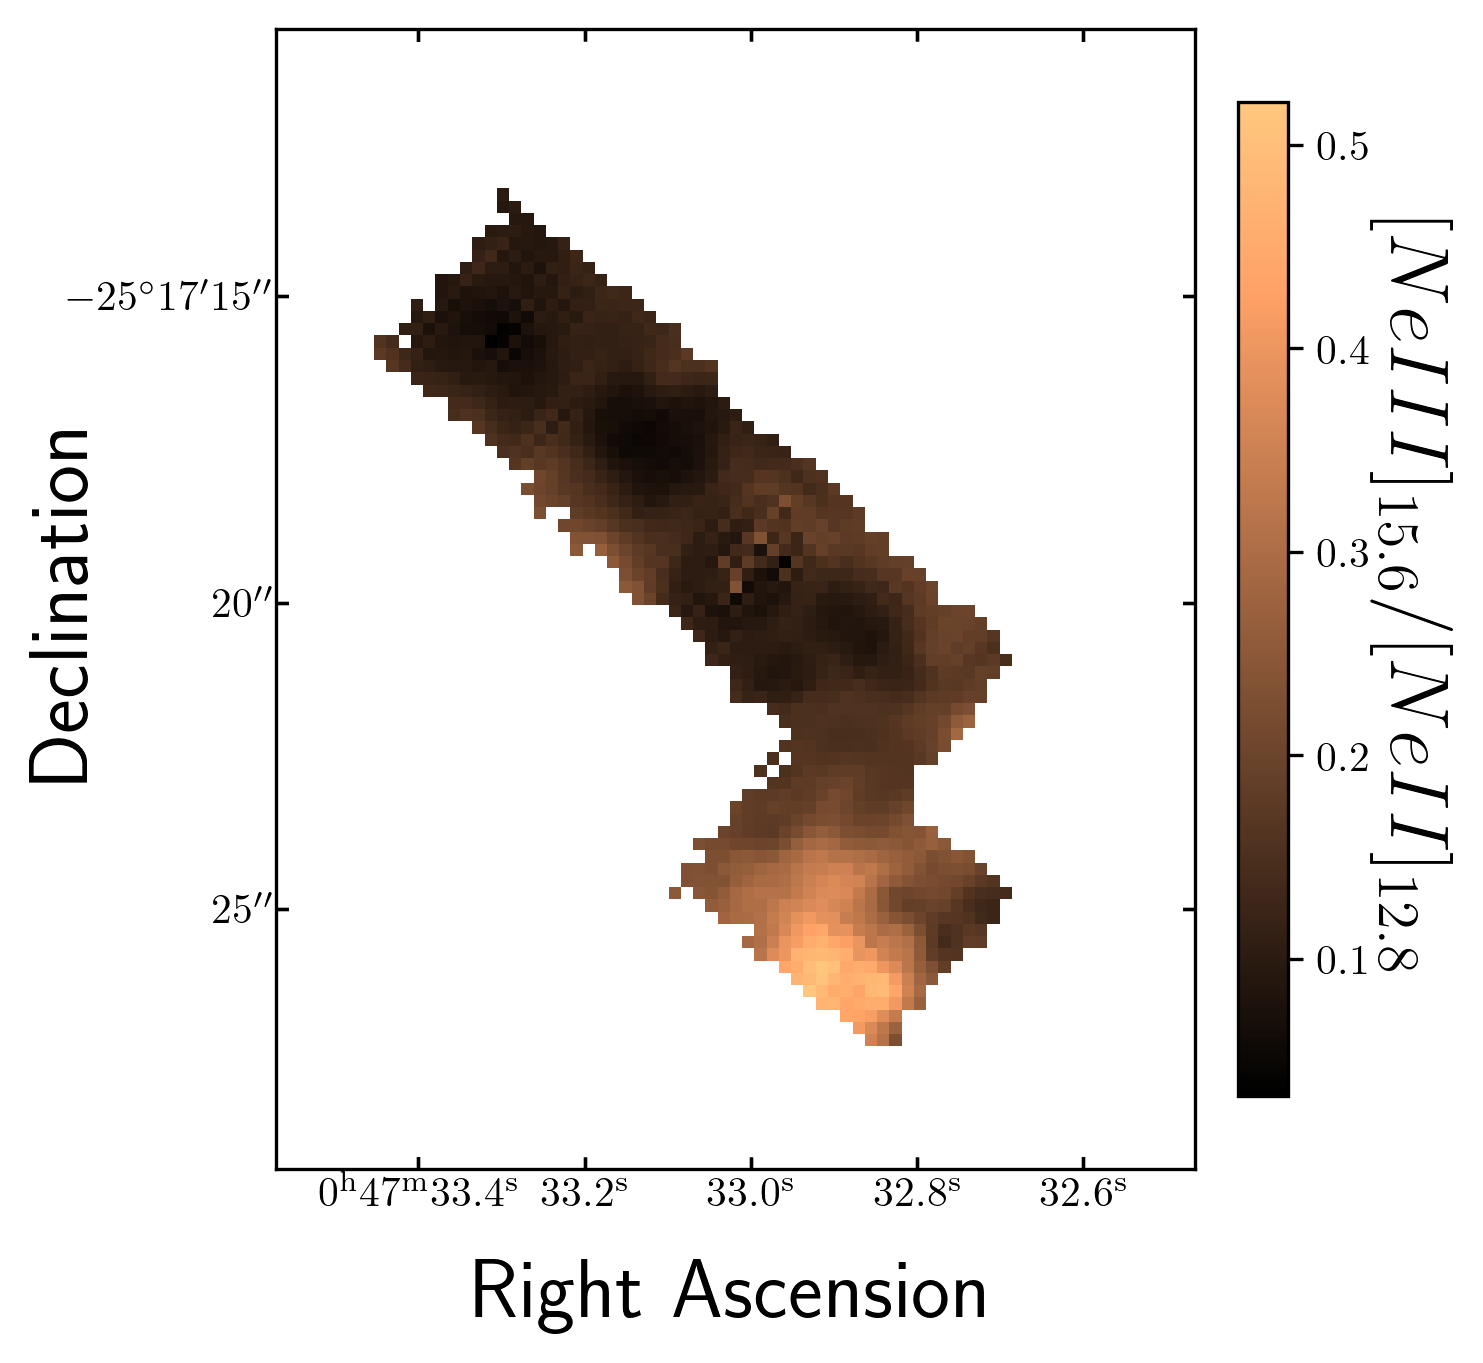

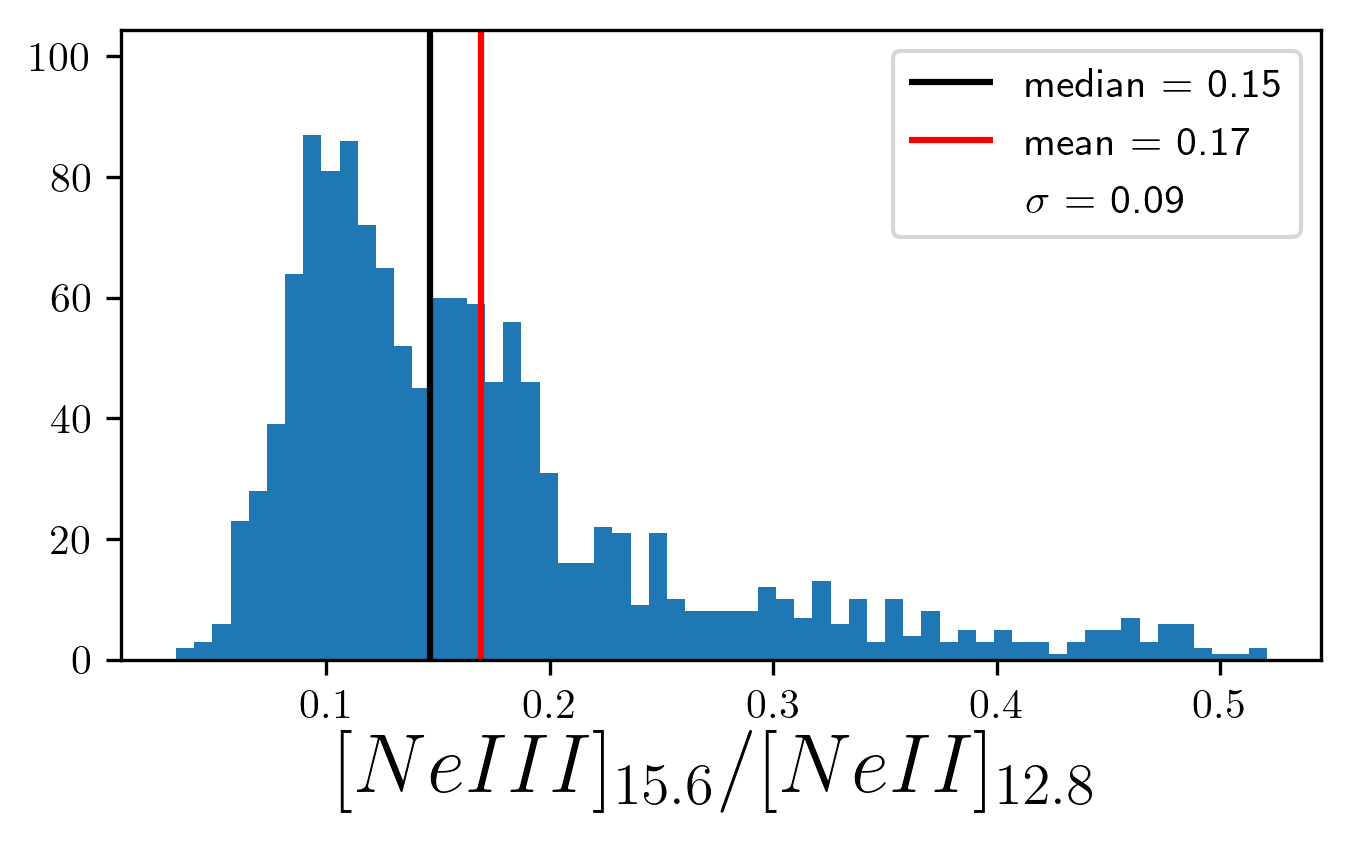

In [34]:
calculate_ratio_map(filenames['neIII'], filenames['neII'], extinction_maps['neIII'], extinction_maps['neII'], lab=r'$[NeIII]_{15.6}/[NeII]_{12.8}$', clrmap='copper')

Hardness diagnostic, sensitive to metallicity

In [26]:
# We can't do this one with the files smoothed to ch3.
# This wasn't a particularly useful map anyway; we can make it again later using the lower-resolution lines if we need.
#calculate_ratio_map(filenames['sIV'], filenames['sIII'], lab=r'$SIV_{10.5}/SIII_{18.7}$', clrmap='copper')

Intermediate ionization

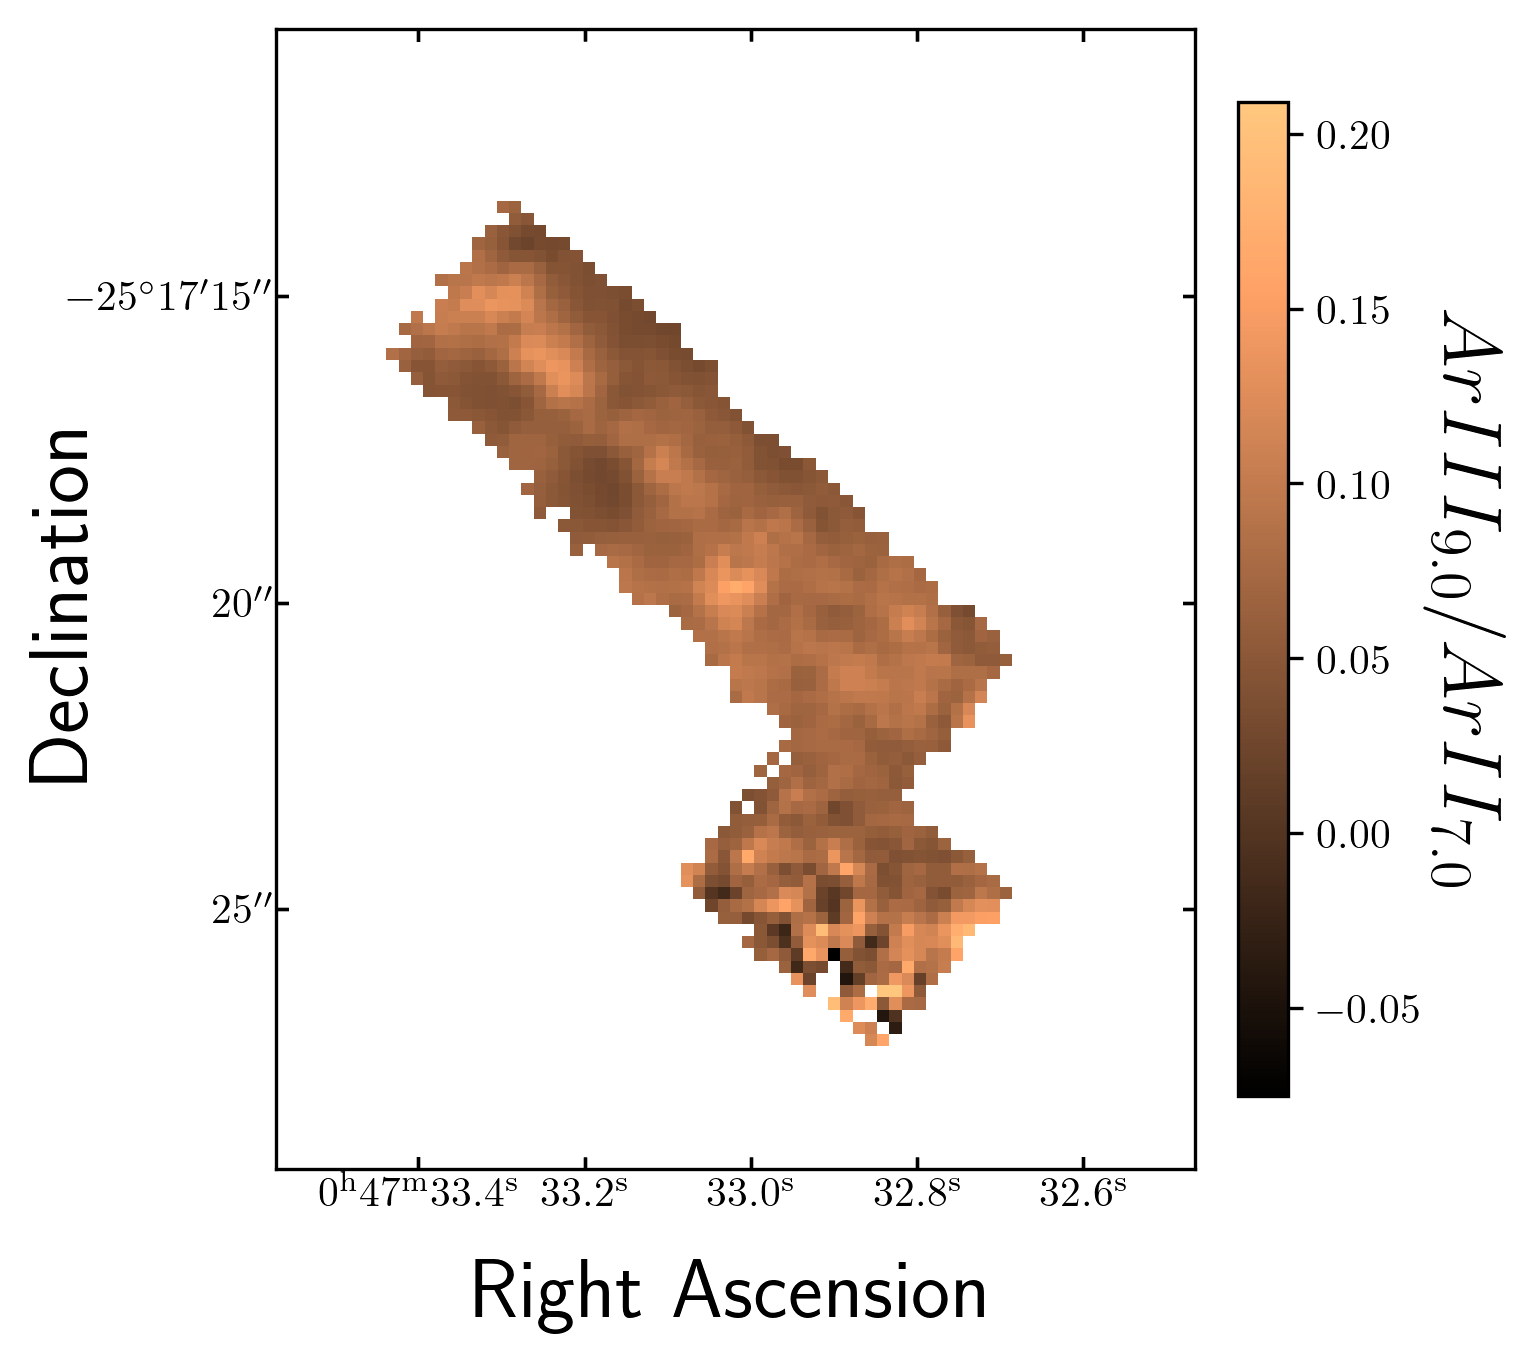

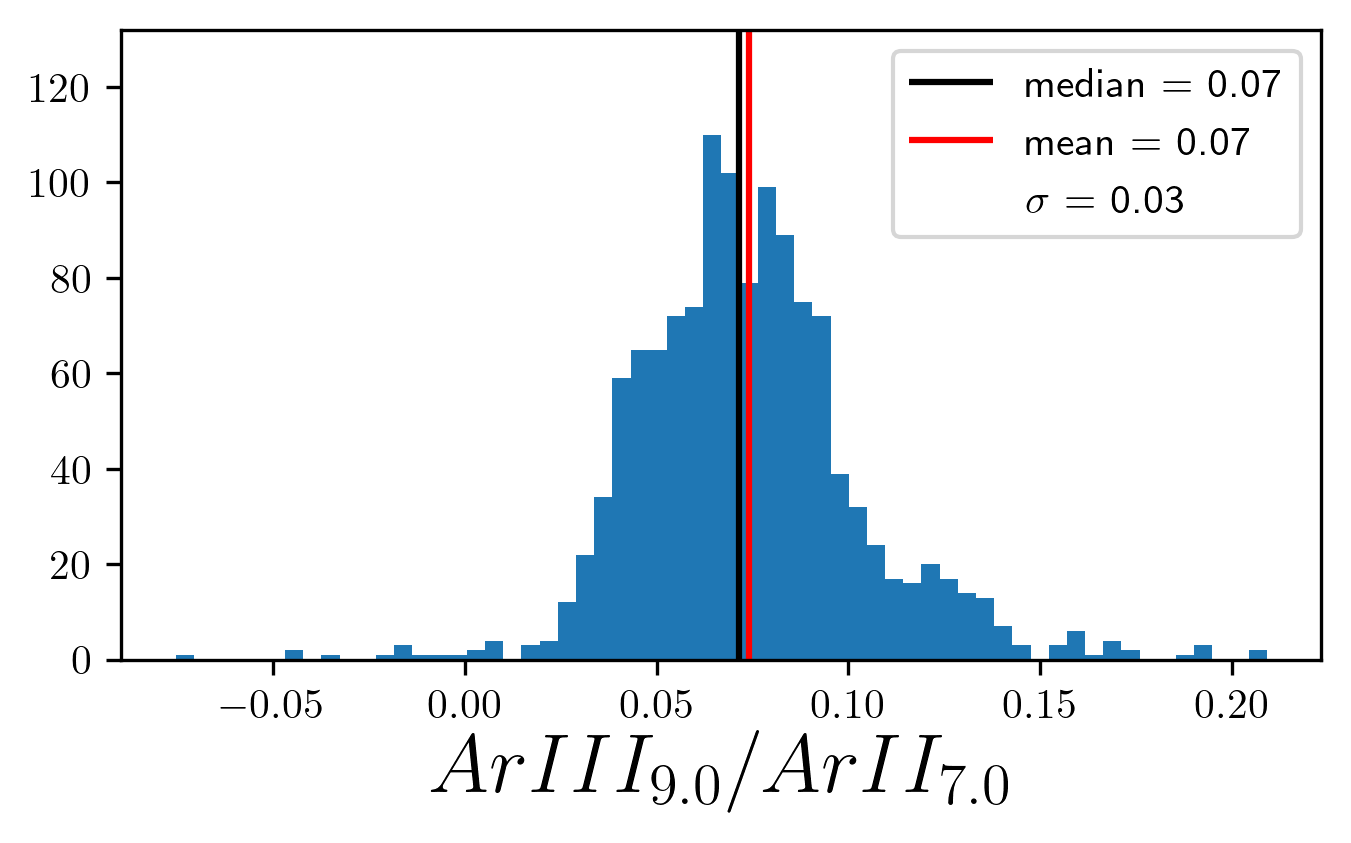

In [35]:
calculate_ratio_map(filenames['arIII'], filenames['arII'], extinction_maps['arIII'], extinction_maps['arII'], lab=r'$ArIII_{9.0}/ArII_{7.0}$', clrmap='copper')

Shocks vs photoionization

In [10]:
# We can't do this one with the files smoothed to ch3.
# This wasn't a particularly useful map anyway; we can make it again later using the lower-resolution lines if we need.
#calculate_ratio_map(filenames['feII_5.3'], filenames['feII_17.9'], lab=r'$FeII_{5.3}/FeII_{17.9}$', clrmap='viridis')

In [11]:
# We can't do this one with the files smoothed to ch3.
# This wasn't a particularly useful map anyway; we can make it again later using the lower-resolution lines if we need.
#calculate_ratio_map(filenames['feII_26'], filenames['feII_5.3'], lab=r'$FeII_{26}/FeII_{5.3}$', clrmap='viridis')

High energy photons (>54.9 eV)

In [12]:
# We can't do this one with the files smoothed to ch3.
# This one is probably good to still make; we will probably need to manually mask out some of the bad pixels in channel 4
# Might need to make a separate function for this
#calculate_ratio_map(filenames['oIV'], filenames['neIII'], lab=r'$OIV_{25.9}/NeIII_{15.6}$', clrmap='plasma')

Possible probe of effective temperature for stars (?) that ionize HII region

In [13]:
# We can't do this one with the files smoothed to ch3.
# It would also be good to do this one. Again, might not be able to reuse the old function.
#calculate_ratio_map(filenames['ne3'], filenames['s3'], lab=r'$NeIII_{15.6}/SIII_{18.7}$', clrmap='plasma')


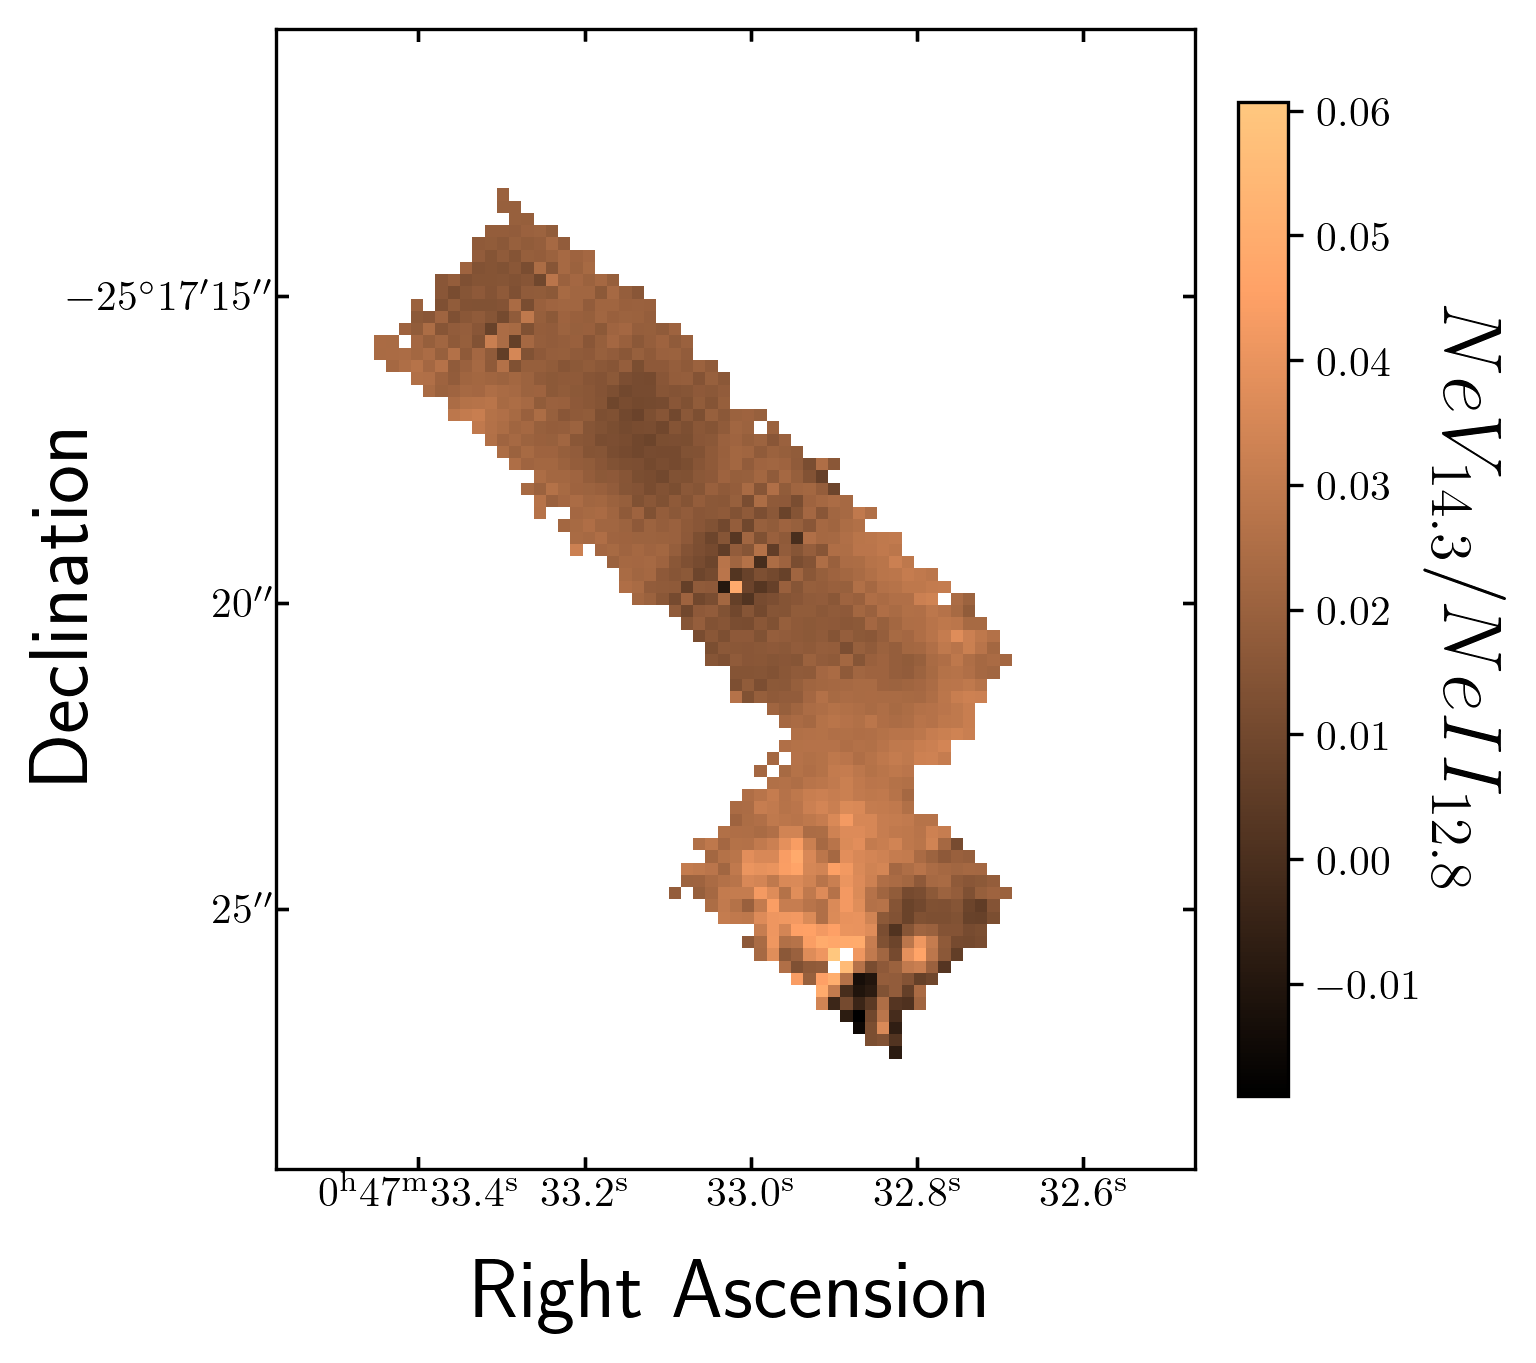

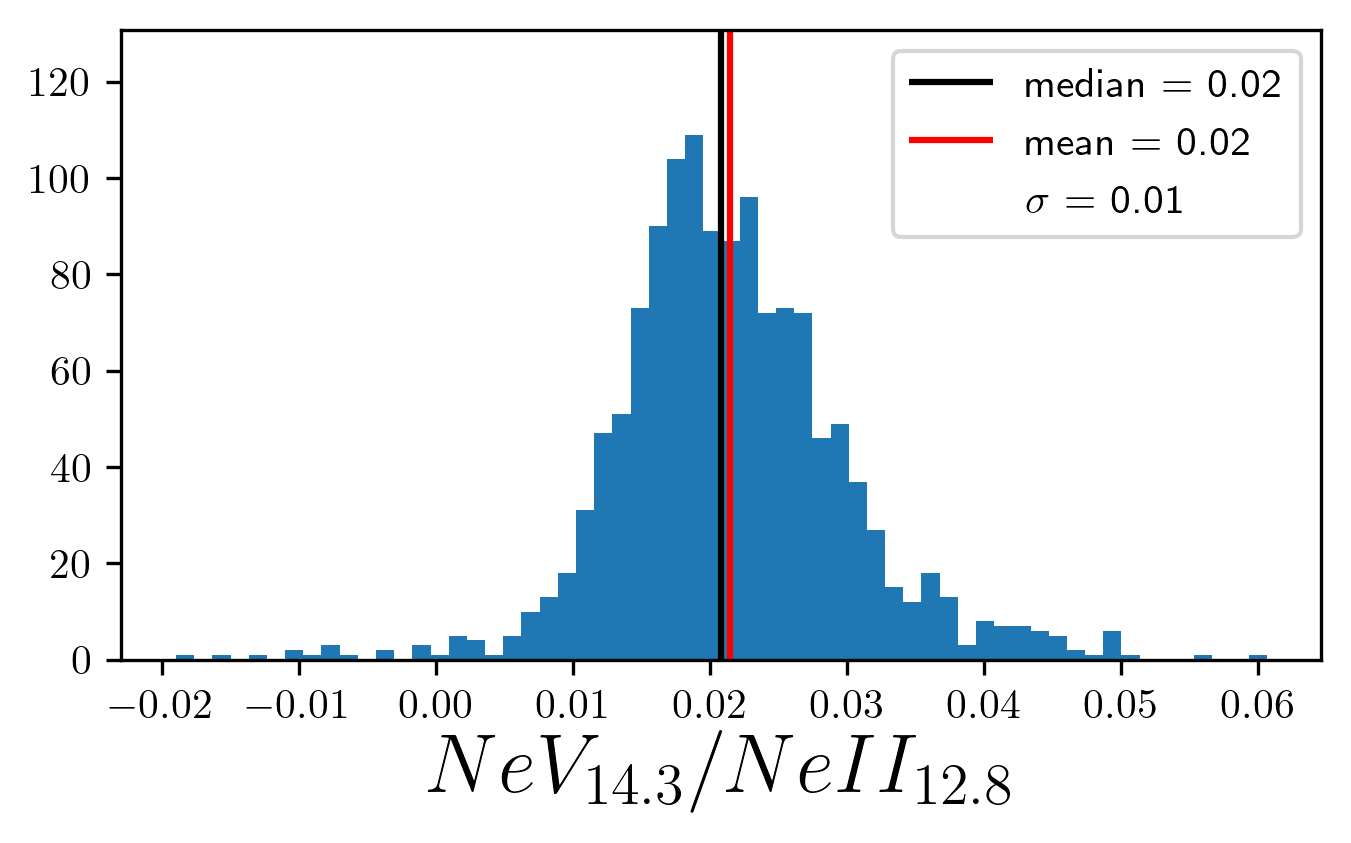

In [38]:
calculate_ratio_map(filenames['neV'], filenames['neII'], extinction_maps['neV'], extinction_maps['neII'], lab=r'$NeV_{14.3}/NeII_{12.8}$', clrmap='copper')